In [25]:
import os
import csv
import obspy
import warnings
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.taup import TauPyModel
warnings.filterwarnings("ignore")

# define the CSV file path
csv_file = "/jan76_dec20.csv"  # replace with the path to your CSV file

# input for start event date (year, month, day)
start_year = int(input("Enter start year: "))
start_month = int(input("Enter start month: "))
start_day = int(input("Enter start day: "))

# input for end event date (year, month, day)
end_year = int(input("Enter end year: "))
end_month = int(input("Enter end month: "))
end_day = int(input("Enter end day: "))

# input for magnitude range (minimum and maximum magnitude)
min_magnitude = float(input("Enter minimum magnitude: "))
max_magnitude = float(input("Enter maximum magnitude: "))

# read the CSV file and extract required information
events_info = []
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        evt = row[0]
        evtime = UTCDateTime(f"{row[1]}-{row[2]}-{row[3]}T{row[4]}:{row[5]}:{row[6]}")
        evmag = float(row[10])
        evlat = float(row[7])
        evlon = float(row[8])
        evdep = float(row[9])

        # Check if the event is within the specified time period and magnitude range
        if (start_year <= evtime.year <= end_year) and \
           (start_month <= evtime.month <= end_month) and \
           (start_day <= evtime.day <= end_day) and \
           (min_magnitude <= evmag <= max_magnitude):
            events_info.append((evt, evtime, evmag, evlat, evlon, evdep))

# print the events within the specified time period and magnitude range with index numbers
print("Events within the specified time period and magnitude range:")
for i, (evt, evtime, evmag, evlat, evlon, evdep) in enumerate(events_info):
    print(f"[{i}] Event: {evt}, Time: {evtime}, Magnitude: {evmag}, Latitude: {evlat}, Longitude: {evlon}, Depth: {evdep}")

# input for selecting an event by index number
selected_index = int(input("Enter the index number of the event you want to choose: "))

# check if the selected index is valid
if 0 <= selected_index < len(events_info):
    selected_event = events_info[selected_index]
    print(f"Selected Event: {selected_event}")
else:
    print("Invalid index number. Please choose a valid index.")

Events within the specified time period and magnitude range:
[0] Event: B040103A, Time: 2003-04-01T08:31:02.000000Z, Magnitude: 5.07, Latitude: 47.06, Longitude: 153.81, Depth: 43.8
[1] Event: B050103A, Time: 2003-05-01T00:14:07.000000Z, Magnitude: 5.43, Latitude: 17.83, Longitude: 148.06, Depth: 15.0
[2] Event: C050103B, Time: 2003-05-01T00:27:04.000000Z, Magnitude: 6.32, Latitude: 39.04, Longitude: 40.53, Depth: 15.0
[3] Event: B050103C, Time: 2003-05-01T04:02:05.000000Z, Magnitude: 5.57, Latitude: -7.14, Longitude: 122.83, Depth: 584.6
[4] Event: B050103D, Time: 2003-05-01T15:48:34.000000Z, Magnitude: 5.18, Latitude: -31.6, Longitude: -178.8, Depth: 107.5
[5] Event: B060103A, Time: 2003-06-01T04:39:21.000000Z, Magnitude: 5.37, Latitude: -9.53, Longitude: 108.37, Depth: 15.0
[6] Event: B060103B, Time: 2003-06-01T09:07:01.000000Z, Magnitude: 5.61, Latitude: -2.73, Longitude: 142.55, Depth: 15.0
[7] Event: B060103C, Time: 2003-06-01T17:50:22.000000Z, Magnitude: 5.28, Latitude: 28.35, L

In [26]:
# input for network and station names
phase_name = input("Enter phase name:")
network_name = input("Enter network name: ")
station_name = input("Enter station name: ")

# initialize the FDSN client (e.g., IRIS, USGS, RESIF, ESEE)
client = Client("IRIS")

# create a TauPy model
model = TauPyModel(model="iasp91")

# calculate event time for the selected event
selected_event = events_info[selected_index]
evtime = selected_event[1]

# request station information (inventory)
inventory = client.get_stations(network=network_name, station=station_name, starttime=evtime - 31104000, endtime=evtime + 31104000)

# Initialize stla and stlo as None in case no matching station is found
stla = None
stlo = None

# extract station latitude and longitude if the station is found
for network_info in inventory:
    for station_info in network_info:
        stla = station_info.latitude
        stlo = station_info.longitude

# check if station information was found
if stla is not None and stlo is not None:
    print(f"Station: {station_name}, Network: {network_name}, Latitude: {stla}, Longitude: {stlo}")
else:
    print(f"No station information found for Station: {station_name}, Network: {network_name}")

# calculate phase arrival time for the selected event
selected_event = events_info[selected_index]
evtime = selected_event[1]
evmag = selected_event[2]
evlat = selected_event[3]
evlon = selected_event[4]
evdep = selected_event[5]

# calculate phase arrival time
dist0, az, baz = obspy.geodetics.base.gps2dist_azimuth(evlat, evlon, stla, stlo) # dist0 is in meters
dist = obspy.geodetics.base.kilometers2degrees(dist0/1000) 
arrivals = model.get_travel_times(source_depth_in_km=evdep, distance_in_degree=dist, phase_list=[f"{phase_name}"])

if not arrivals:
    print(f"{phase_name} phase not found for the selected event.")
else:
    phase_time = evtime + arrivals[0].time.copy()
    print(f"{phase_name} phase arrival time: {phase_time}")

    # request waveform data for the selected phase
    start_time = phase_time - 100  # Adjust the time window as needed
    end_time = phase_time + 400    # Adjust the time window as needed

    # loop through the components and process each one
    for component in ["BHZ", "BHN", "BHE"]:  # Update with your desired components
        st = client.get_waveforms(network_name, station_name, "*", component, start_time, end_time)

        if st:
            # save the waveform data to a SAC file with the specified format
            sac_filename = f"{selected_event[0]}.{network_name}.{station_name}.{component}.SAC"
            st[0].stats.sac = {
                'o': evtime - start_time,
                'stla': stla,
                'stlo': stlo,
                'evla': evlat,
                'evlo': evlon,
                'evdp': evdep,
                'mag': evmag,
                'dist': dist0,
                'az': az,
                'baz': baz,
                'gcarc': dist0,
                'depmen': 0,
                'cmpaz': 0,
                'cmpinc': 0,
                'leven': 1,
                'khole': ' ' * 8,
                'nzyear': phase_time.year,
                'nzjday': phase_time.julday,
                #'nzday': evtime.day,
                'nzhour': phase_time.hour,
                'nzmin': phase_time.minute,
                'nzsec': phase_time.second,
                'nzmsec': phase_time.microsecond // 1000,
            }
            st.write(sac_filename, format="SAC")
            print(f"Waveform data and header saved to {sac_filename}")
        else:
            print(f"No waveform data found for {phase_name} phase at Station: {station_name}, Network: {network_name}, Component: {component}")

Station: HGN, Network: NL, Latitude: 50.764, Longitude: 5.9317
S phase arrival time: 2003-06-01T05:02:59.667756Z
Waveform data and header saved to B060103A.NL.HGN.BHZ.SAC
Waveform data and header saved to B060103A.NL.HGN.BHN.SAC
Waveform data and header saved to B060103A.NL.HGN.BHE.SAC


In [28]:
from obspy import read, Stream
st = Stream()

st = read("B060103A.NL.HGN.BHZ.SAC")
st += read("B060103A.NL.HGN.BHN.SAC")
st += read("B060103A.NL.HGN.BHE.SAC")

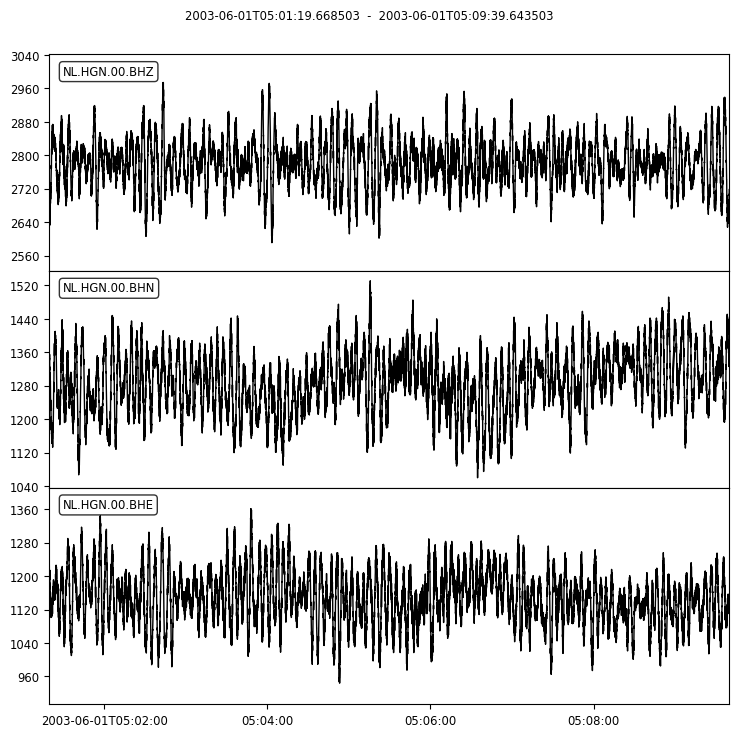

In [29]:
st.plot();

In [33]:
st[0].stats

         network: NL
         station: HGN
        location: 00
         channel: BHZ
       starttime: 2003-06-01T05:01:19.668503Z
         endtime: 2003-06-01T05:09:39.643503Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 20000
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.025, 'depmin': 2591.0, 'depmax': 2974.0, 'b': -99.9985, 'e': 399.9765, 'o': -1318.6677, 'stla': 50.764, 'stlo': 5.9317, 'evla': -9.53, 'evlo': 108.37, 'evdp': 15.0, 'mag': 5.37, 'dist': 11698665.0, 'az': 320.1154, 'baz': 86.27619, 'gcarc': 11698665.0, 'depmen': 2783.1938, 'cmpaz': 0.0, 'cmpinc': 0.0, 'nzyear': 2003, 'nzjday': 152, 'nzhour': 5, 'nzmin': 2, 'nzsec': 59, 'nzmsec': 667, 'nvhdr': 6, 'npts': 20000, 'iftype': 1, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'kstnm': 'HGN', 'khole': '00', 'kcmpnm': 'BHZ', 'knetwk': 'NL'})

In [31]:
st[0].stats.sac

AttribDict({'delta': 0.025, 'depmin': 2591.0, 'depmax': 2974.0, 'b': -99.9985, 'e': 399.9765, 'o': -1318.6677, 'stla': 50.764, 'stlo': 5.9317, 'evla': -9.53, 'evlo': 108.37, 'evdp': 15.0, 'mag': 5.37, 'dist': 11698665.0, 'az': 320.1154, 'baz': 86.27619, 'gcarc': 11698665.0, 'depmen': 2783.1938, 'cmpaz': 0.0, 'cmpinc': 0.0, 'nzyear': 2003, 'nzjday': 152, 'nzhour': 5, 'nzmin': 2, 'nzsec': 59, 'nzmsec': 667, 'nvhdr': 6, 'npts': 20000, 'iftype': 1, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'kstnm': 'HGN', 'khole': '00', 'kcmpnm': 'BHZ', 'knetwk': 'NL'})